In [18]:
#@formatter:off
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve,\
    roc_curve, roc_auc_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

%matplotlib inline
sns.set_theme(style='whitegrid')
#@formatter:on

## Data fetching

In [3]:
mnist = fetch_openml('mnist_784')
# mnist.shape

In [23]:
X, y = np.array(mnist['data'], dtype=np.float64), np.array(mnist['target'], dtype=np.float64)
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


2.0


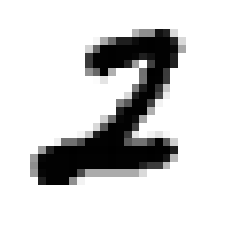

In [42]:
def plot_digit(image, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.imshow(image, cmap=mpl.cm.binary, interpolation='nearest')
    ax.axis('off')

rnum = np.random.randint(0, X.shape[0])
some_digit = X[rnum]
sd_image = some_digit.reshape(28, 28)
plot_digit(sd_image)
print(y[rnum])

## Set partition

In [26]:
shuffle_index = np.random.permutation(60000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
#SGD for SVM
sgd_clf = SGDClassifier(random_state=228, max_iter=1000 ** 3)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([False])

In [14]:
skfolds = StratifiedKFold(n_splits=3, random_state=228, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = np.sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.96105
0.96275
0.9653


In [15]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96495, 0.97205, 0.9666 ])

In [16]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9097 , 0.90845, 0.9108 ])

## Metrics

In [17]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[54008,   571],
       [ 1357,  4064]])

In [18]:
print(precision_score(y_train_5, y_train_pred))  # TP / (TP + FP)
print(recall_score(y_train_5, y_train_pred))  # TP / (TP + FN)
print(f1_score(y_train_5, y_train_pred))  # 2 / (1 / prec + 1 / rec)

0.87680690399137
0.7496771813318576
0.8082736674622115


In [19]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
print(y_scores)

[-3810.5546514]
[-16891.87454036  -8522.1213032  -10409.68514072 ...   4499.36489179
 -14182.32079717 -22900.75705272]


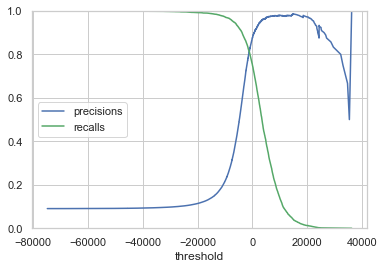

In [20]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b-', label='precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recalls')
    plt.xlabel('threshold')
    plt.legend(loc='center left')
    plt.ylim([0, 1])


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Text(0, 0.5, 'precisions')

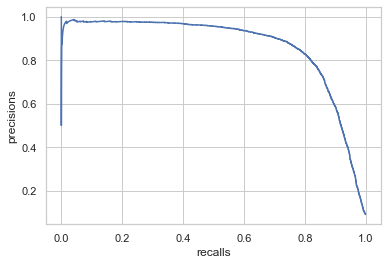

In [21]:
plt.plot(recalls, precisions)
plt.xlabel('recalls')
plt.ylabel('precisions')

In [22]:
y_train_pred_90 = (y_scores > 3500)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9569701280227596
0.49640287769784175


0.9663204242469648

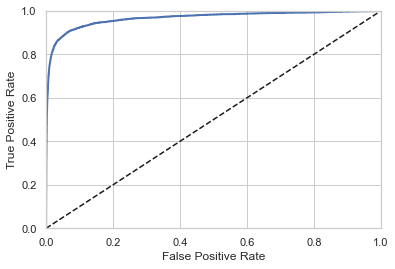

In [23]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, lw=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
plot_roc_curve(fpr, tpr)
roc_auc_score(y_train_5, y_scores)

In [24]:
forest_clf = RandomForestClassifier(random_state=228)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_scores_forest = y_probas_forest[:, 1]
print(y_probas_forest)
print(y_scores_forest)

[[0.96 0.04]
 [0.94 0.06]
 [1.   0.  ]
 ...
 [0.17 0.83]
 [1.   0.  ]
 [1.   0.  ]]
[0.04 0.06 0.   ... 0.83 0.   0.  ]


0.9984778490540254


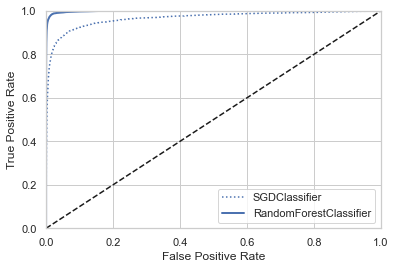

In [25]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr, tpr, 'b:', label='SGDClassifier')
plot_roc_curve(fpr_forest, tpr_forest, 'RandomForestClassifier')
plt.legend()
print(roc_auc_score(y_train_5, y_scores_forest))

## Multiclass classification

In [26]:
sgd_clf.fit(X_train, y_train)
print(sgd_clf.predict([some_digit]))
print(sgd_clf.decision_function([some_digit]))
print(sgd_clf.classes_)

['3']
[[-36905.89817399 -12468.79472829  -5859.31474826   2941.52489825
  -18976.60635624  -7722.83997899 -14876.29974376 -22729.80466397
   -3546.47924668 -13533.85296553]]
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [27]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=228))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array(['3'], dtype=object)

In [28]:
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([some_digit]))
print(forest_clf.predict_proba([some_digit]))

['3']
[[0.   0.   0.02 0.97 0.   0.   0.   0.   0.01 0.  ]]


In [ ]:
print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy'))
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'))

[0.86945 0.86515 0.88075]


In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_m = confusion_matrix(y_train, y_train_pred)
print(conf_m)
plt.matshow(conf_m, cmap=plt.cm.gray)

In [ ]:
row_sums = conf_m.sum(axis=1, keepdims=True)
print(row_sums)
norm_conf_m = conf_m / row_sums
print(norm_conf_m)
np.fill_diagonal(norm_conf_m, 0)
plt.matshow(norm_conf_m, cmap=plt.cm.gray)

## Multi-label and multi-output classification

In [39]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
print(knn_clf.predict([some_digit]))
print(y[rnum])

[[False  True]]
1.0


In [40]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9768275974348433

[[ 8 45 93 ... 64  0 18]
 [34 35  3 ...  1 82 78]
 [21 98 18 ... 53 63 13]
 ...
 [74 32 10 ...  6 96 80]
 [25 18 51 ... 97 31 83]
 [86 52 55 ... 97 82 82]]


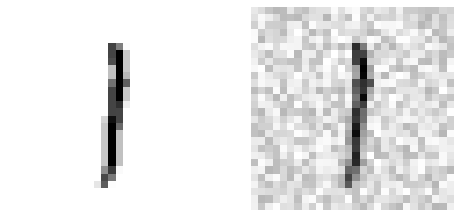

In [43]:
noise = np.random.randint(0, 100, (len(X_train), 784))
print(noise)
X_train_mod = X_train + noise
y_train_mod = X_train

rnum1 = np.random.randint(0, 60000)
snd_img = X_train_mod[rnum1].reshape(28, 28)
sd_img = X_train[rnum1].reshape(28, 28)
fig = plt.figure(figsize=(8, 16))
for i, img in enumerate([sd_img, snd_img]):
    ax = fig.add_subplot(1, 2, i + 1)
    plot_digit(img, ax)


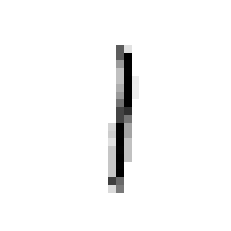

In [46]:
knn_clf.fit(X_train_mod, X_train)
clear_digit = knn_clf.predict([X_train_mod[rnum1]]).reshape(28, 28)
plot_digit(clear_digit)